In [ ]:
#dataset : https://www.kaggle.com/datasets/kmader/synthetic-word-ocr
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
map_base_dir = '../input/'
map_img_dir = '../input/synthetic-word-ocr/train/images/'

In [ ]:
json_path = os.path.join('../input/synthetic-word-ocr/annotation.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

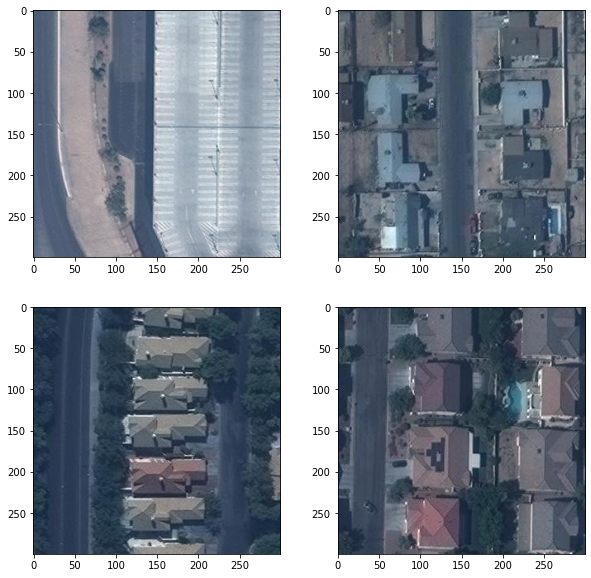

In [ ]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [ ]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

id  image_id                                       segmentation  \
1589021  2168652    254304  [[249, 208, 215, 208, 215, 200, 215, 177, 227,...   
1284686  2373953    278232  [[179, 167, 201, 191, 185, 201, 193, 209, 164,...   
1497456   360444     42242  [[195, 111, 180, 111, 180, 103, 195, 103, 195,...   

           area                 bbox  category_id  iscrowd  
1589021  2660.0  [160, 215, 113, 73]          100        0  
1284686  3094.0   [157, 110, 69, 91]          100        0  
1497456   120.0   [111, 180, 84, 15]          100        0

In [ ]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

280741 + 2395553 -> 2395553


id_x  image_id                                       segmentation  \
200451    875182    102679  [[77.99999999999999, 0.0, 79.0, 148.0, 69.0, 1...   
2263113  1561359    183149  [[300.0, 51.99999999999999, 296.0, 51.99999999...   

            area                                               bbox  \
200451   12509.0  [0.0, -1.8369701987210297e-14, 153.0, 79.00000...   
2263113   1802.0            [51.99999999999999, 271.0, 248.0, 29.0]   

         category_id  iscrowd    id_y         file_name  width  height  
200451           100        0  102679  000000102679.jpg    300     300  
2263113          100        0  183149  000000183149.jpg    300     300

In [ ]:
def create_boxes(in_rows):
    #TODO: this seems to get a few of the boxes wrong so we stick to segmentation polygons instead
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']

        box_list += [Rectangle((start_x, start_y),
                         wid_y , wid_x
                         )]
    return box_list

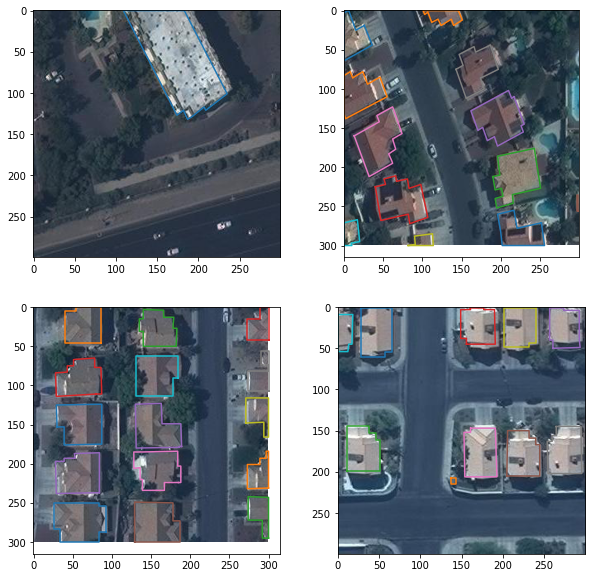

In [ ]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [ ]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]),
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(),
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

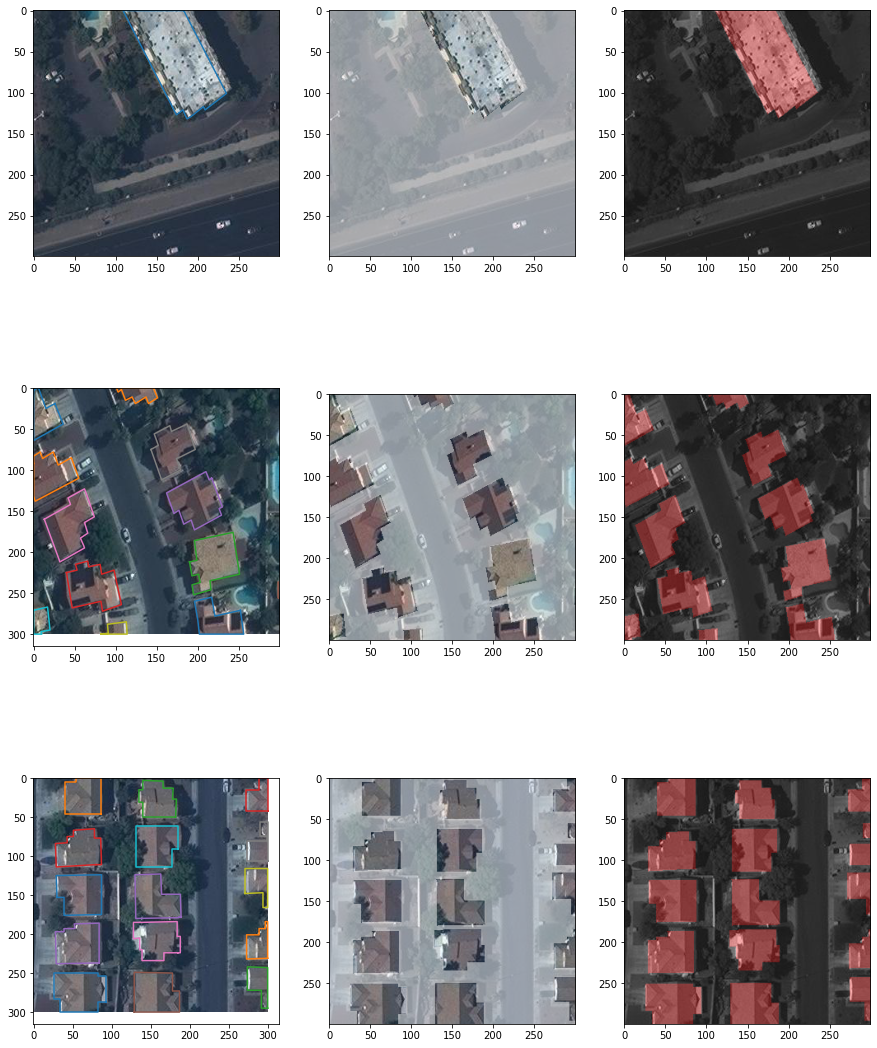

In [ ]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data,
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)

    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))


In [ ]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

1794753 training boxes
600800 validation boxes


In [ ]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 8)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


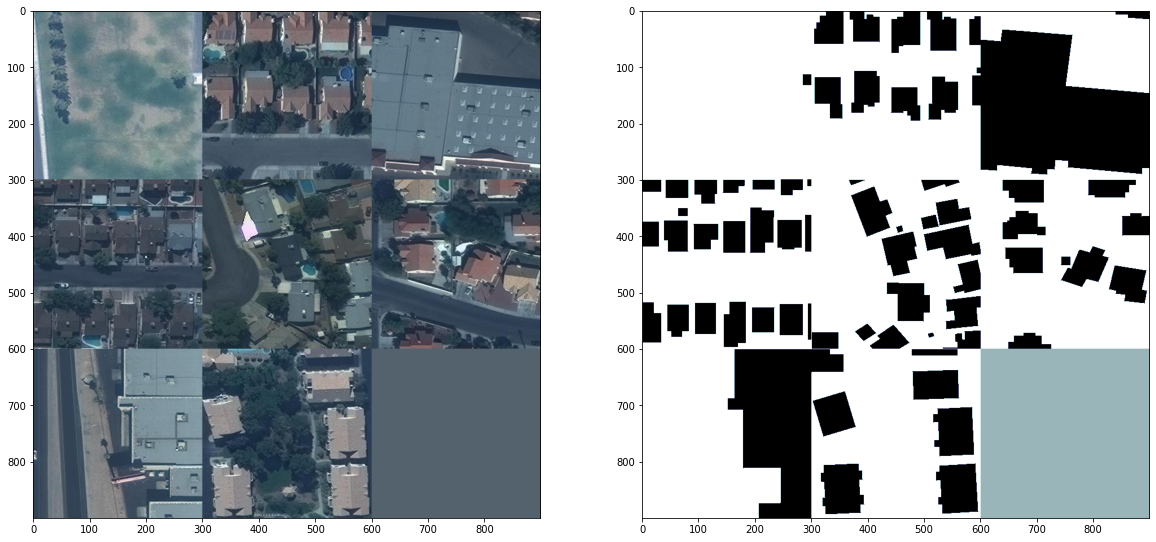

In [ ]:

from skimage.util import montage as montage2d
t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')

In [ ]:
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
BATCH_SIZE = 24




In [ ]:
from keras import models, layers
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3),
                             activation='linear',
                             padding='same',
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

in_layer = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c = conv_bn(pp_in_layer, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH)

skip_layers = [pp_in_layer]
for j in range(BLOCK_COUNT):
    depth_steps = int(np.log2(t_x.shape[1])-2)
    d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True)
                                        for i in range(depth_steps)])
    d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
    d = layers.BatchNormalization()(d)
    d = layers.Activation('elu')(d)
    # bottleneck
    d = conv_bn(d, BASE_DEPTH*2**(j+1))
    skip_layers += [c]
    c = d
d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
seg_model = models.Model(inputs = [in_layer],
                    outputs = [d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 300, 300, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 300, 300, 3)  12          gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 300, 300, 8)  216         batch_normalization[0][0]        
______________________________________________________________________________________________

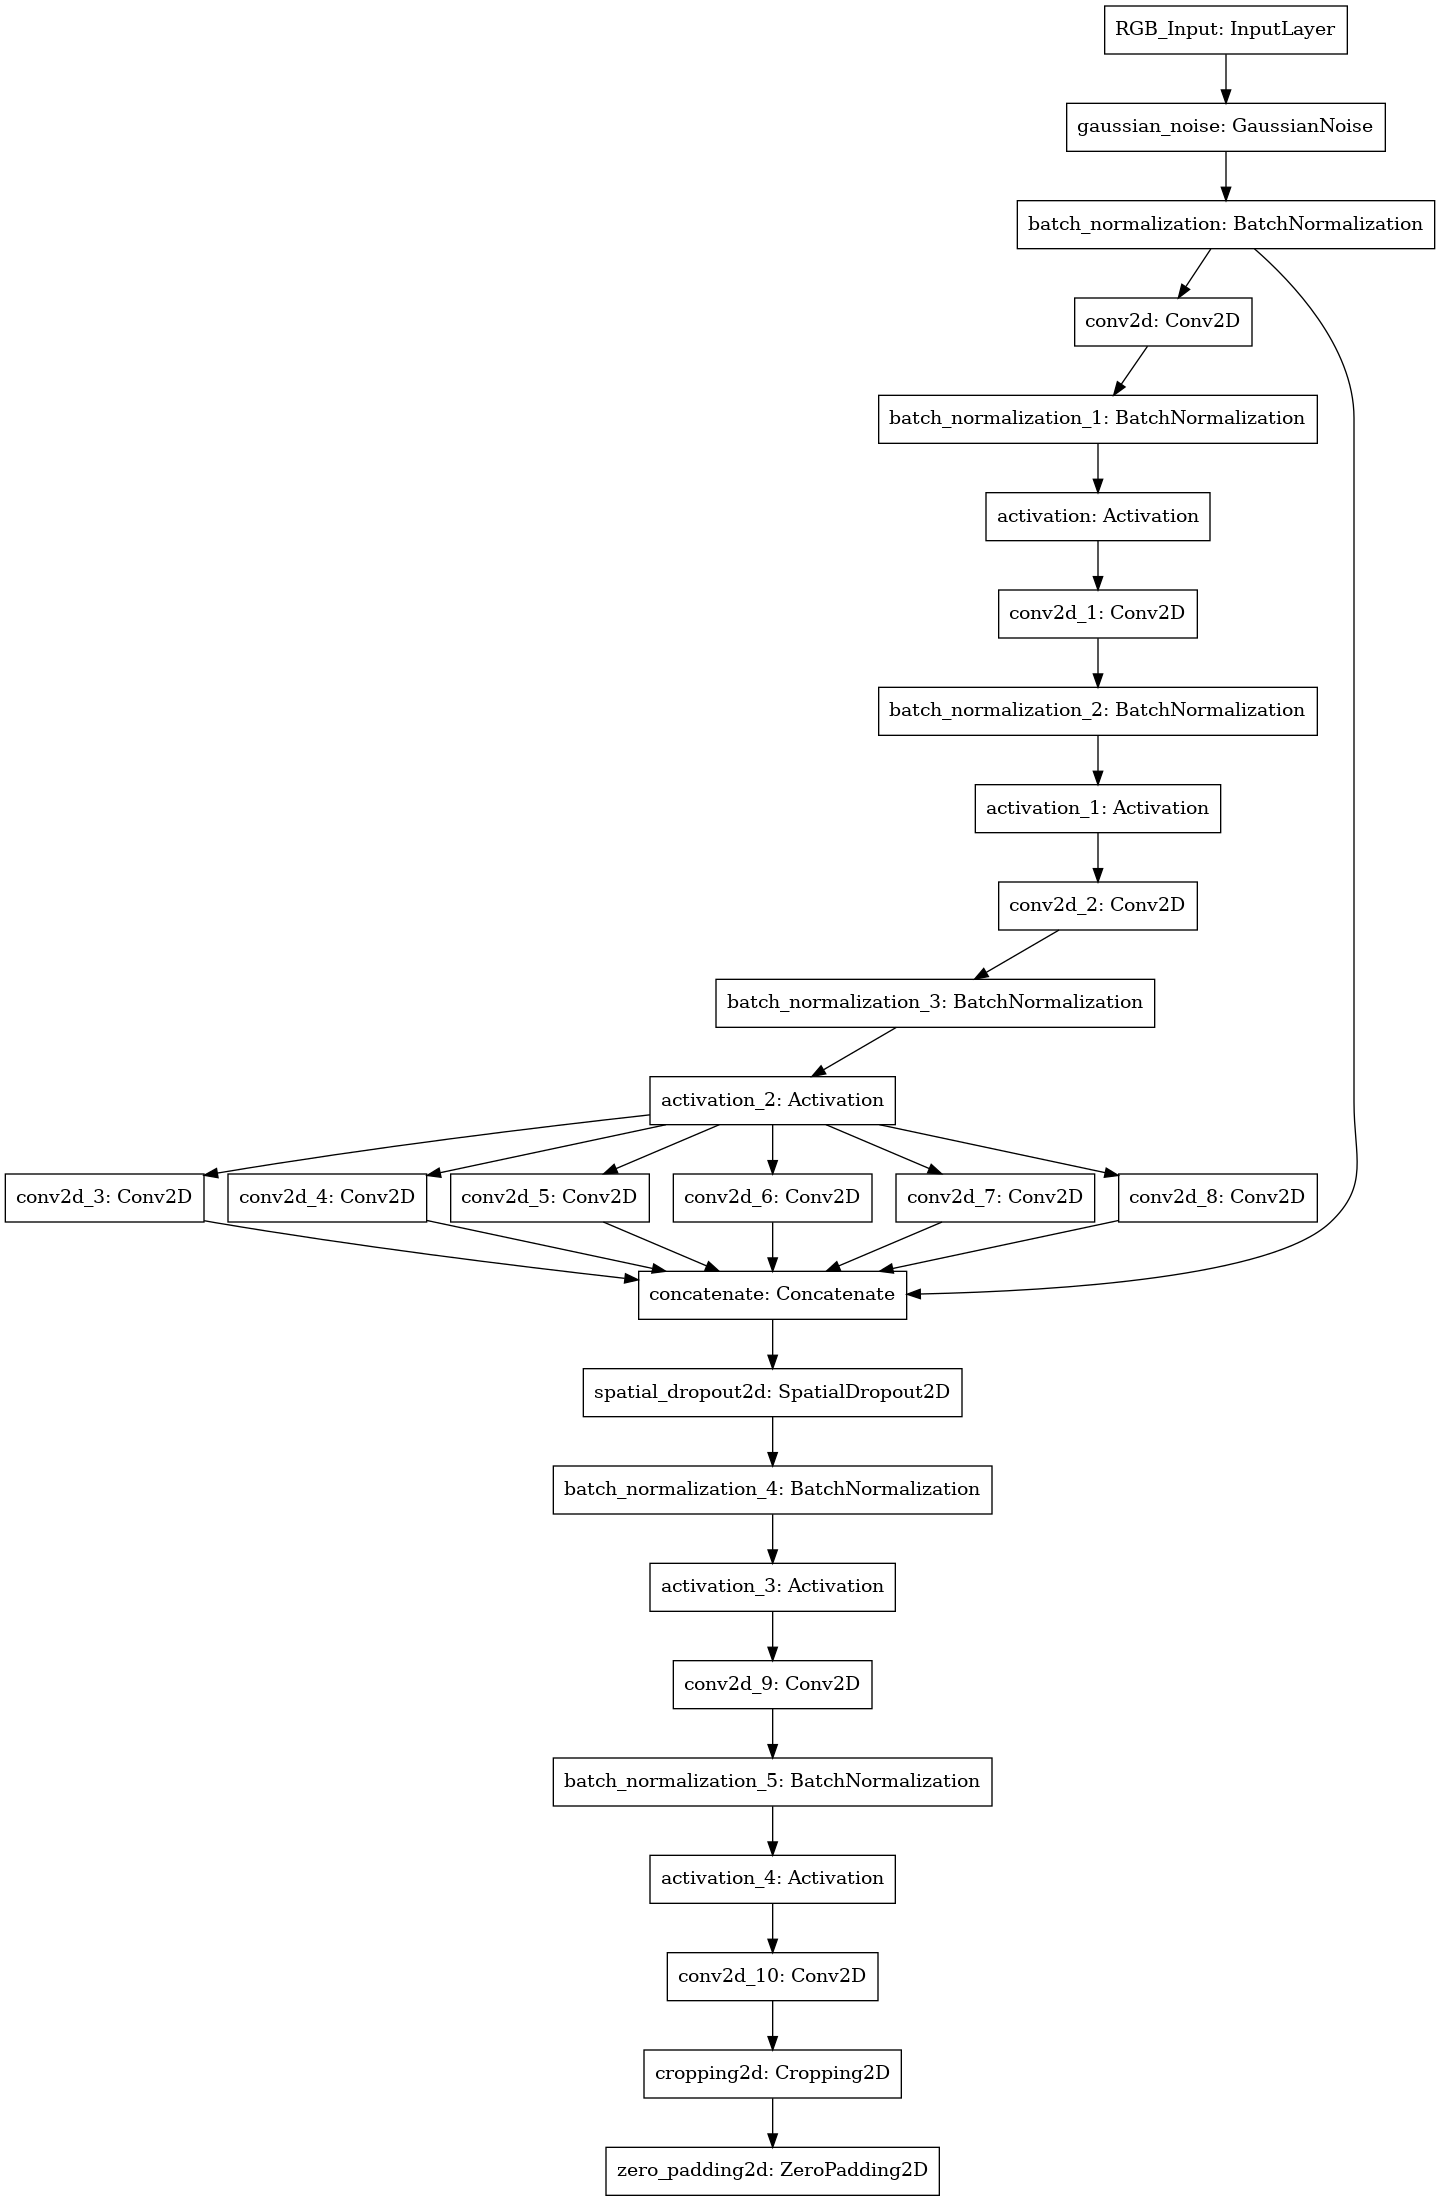

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(seg_model,'seg_model.png')


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef",
                      mode="max",
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 0.05*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy',
                                                                              true_positive_rate])


In [ ]:
valid_gen = batch_img_gen(valid_df, BATCH_SIZE)

In [ ]:
valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit_generator(batch_img_gen(train_df, BATCH_SIZE),
                             steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                             epochs=20,
                             validation_data = valid_gen,
                             validation_steps = min(train_ids.shape[0]//BATCH_SIZE, 50),
                             callbacks=callbacks_list,
                            workers=1, use_multiprocessing=False
                                       )]

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: -0.4013 - dice_coef: 0.4741 - binary_accuracy: 0.7385 - true_positive_rate: 0.6553

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


100/100 [==============================] - 241s 2s/step - loss: -0.4013 - dice_coef: 0.4741 - binary_accuracy: 0.7385 - true_positive_rate: 0.6553 - val_loss: -0.4050 - val_dice_coef: 0.4848 - val_binary_accuracy: 0.7327 - val_true_positive_rate: 0.6603

Epoch 00001: val_dice_coef improved from 0.46284 to 0.48477, saving model to seg_model_weights.best.hdf5
Epoch 2/20
100/100 [==============================] - 215s 2s/step - loss: -0.4030 - dice_coef: 0.4767 - binary_accuracy: 0.7375 - true_positive_rate: 0.6448 - val_loss: -0.4092 - val_dice_coef: 0.4896 - val_binary_accuracy: 0.7415 - val_true_positive_rate: 0.6603

Epoch 00002: val_dice_coef improved from 0.48477 to 0.48964, saving model to seg_model_weights.best.hdf5
Epoch 3/20
100/100 [==============================] - 224s 2s/step - loss: -0.4097 - dice_coef: 0.4816 - binary_accuracy: 0.7435 - true_positive_rate: 0.6483 - val_loss: -0.4153 - val_dice_coef: 0.4921 - val_binary_accuracy: 0.7479 - val_true_positive_rate: 0.6434

Epo

In [ ]:
seg_model.save('building.h5')

In [ ]:
from keras.models import load_model


In [ ]:
import tensorflow as tf
from keras import backend as K

def true_positive_rate(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def dice_coef(y_true, y_pred):
    smooth = 1e-6  # Sayısal stabilite için eklenir
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

from tensorflow.keras.models import load_model

# Özel kayıp ve metrik fonksiyonlarını burada tanımlayın
def dice_p_bce(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = 1 - tf.reduce_mean((2.0 * tf.reduce_sum(y_true * y_pred) + 1e-6) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-6))
    return bce + dice

def dice_coef(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Modeli yüklerken custom_objects parametresine her iki fonksiyonu ekleyin
from keras.models import load_model

seg_model = load_model(
    'building.h5',
    custom_objects={
        'dice_p_bce': dice_p_bce,
        'dice_coef': dice_coef,
        'true_positive_rate': true_positive_rate
    }
)


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


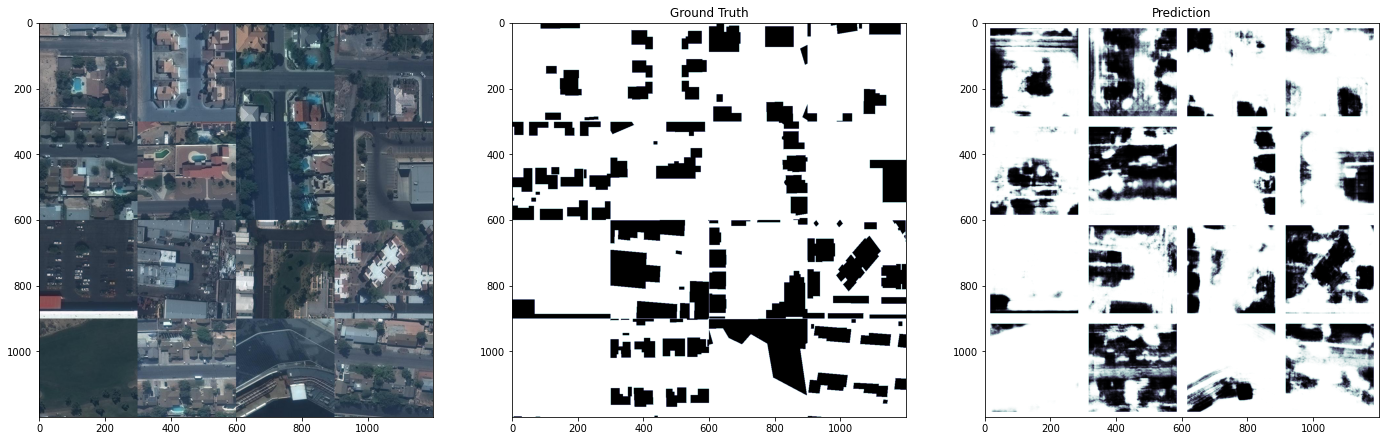

In [ ]:
# Validasyon veri kümesinden bir örnek alın
t_x, t_y = next(valid_gen)

if t_x.shape[0] > 16:
    t_x = t_x[:16]
    t_y = t_y[:16]

pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap='bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap='bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)



x (16, 300, 300, 3) float32 0.0 1.0
y (16, 300, 300, 1) float32 0.0 1.0


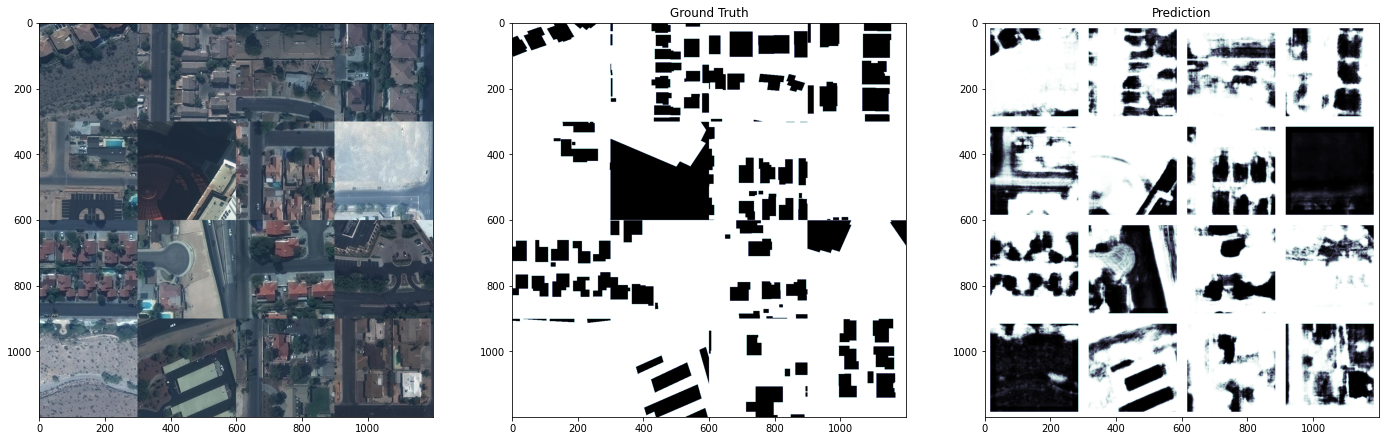

In [ ]:
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]

print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)

In [ ]:
from skimage.measure import label, regionprops
from matplotlib.patches import Rectangle

def plot_prediction_with_boxes(pred_mask, ax):
    labeled_mask = label(pred_mask)
    for region in regionprops(labeled_mask):
        # Dikdörtgen çerçevenin sınırlarını hesapla
        min_row, min_col, max_row, max_col = region.bbox
        rect = Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                         linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)


IndexError: index 4 is out of bounds for axis 0 with size 4

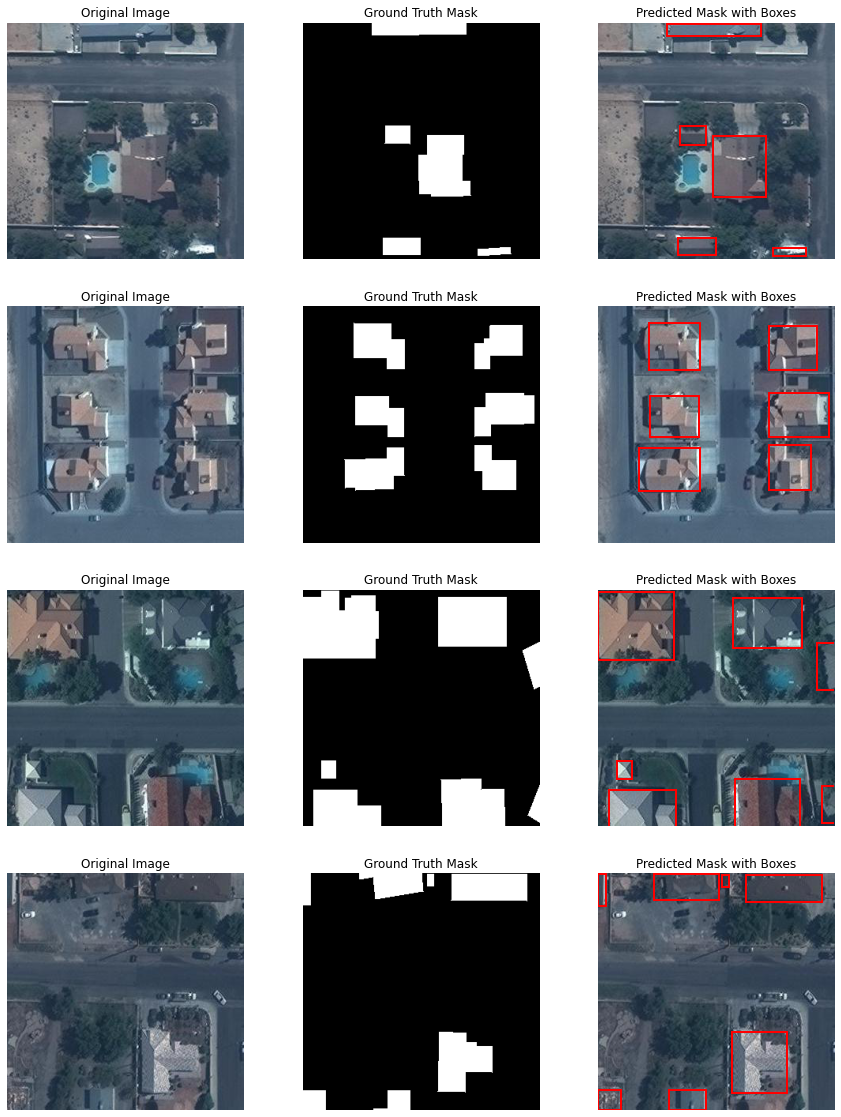

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Eğer OpenCV kullanıyorsanız

# Kırmızı kutuları çizen fonksiyon
def draw_boxes_on_image(image, mask, ax):
    # Binary maske üzerinden konturları bul
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Kutu çizme
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # 4x3 şeklinde düzenledik
for i, (img, true_mask, pred_mask) in enumerate(zip(t_x, t_y, pred_y)):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    ax3 = axs[i, 2]

    # Orijinal Görüntü
    ax1.imshow(img)
    ax1.set_title("Original Image")
    ax1.axis('off')

    # Gerçek Maske
    ax2.imshow(true_mask[:, :, 0], cmap='gray')
    ax2.set_title("Ground Truth Mask")
    ax2.axis('off')

    # Tahmin Edilen Maske ile Çerçeve
    ax3.imshow(img)  # Gerçek görüntüyü göster
    draw_boxes_on_image(img, true_mask[:, :, 0] > 0.5, ax3)  # Gerçek maske kullanılarak kutuları çiz
    ax3.set_title("Predicted Mask with Boxes")
    ax3.axis('off')

plt.tight_layout()
plt.show()
